# Определение возраста покупателей

## Исследовательский анализ данных

Для начала выгрузим все необходимые для дальнейшей работы библиотеки.

In [1]:
import numpy as np
import pandas as pd
 
from PIL import Image
import matplotlib.pyplot as plt
 
 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Зададим переменную labels, которой передадим наш датафрейм с лицами.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Теперь рассмотрим более детально наш датасет. Для этого вызовем метод describe.

In [3]:
labels.describe(include= 'all')

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,002391.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


Как мы видим из полученных данных - наш датасет состоит из 7591 строки и 2-х столбцов (имя файла и реальный возраст). Здесь нас не сильно интересуют значения NaN, так как в столбце "имя файла" записаны названия и расширение .jpeg, что не дает посчитать по данному столбцу ни среднее, ни максимально, ни какие-либо другие значения.

Размер нашей выборки составляет 7591 значение. В дальнейшем мы будем делить выборку на тренировочну и тестовую в пропорциях 75/25. Перейдем к построению графика распределения возрастов в выборке.

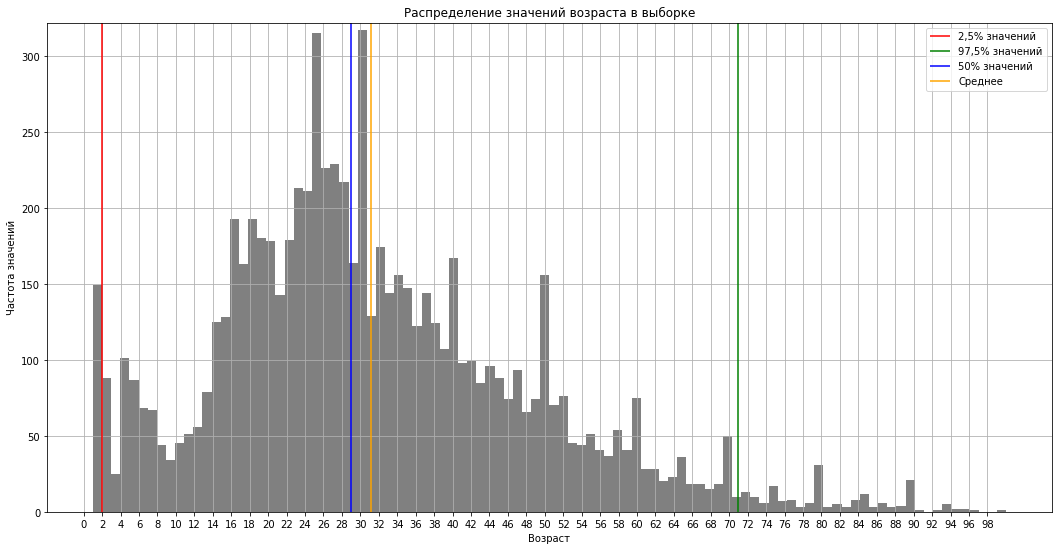

In [6]:
labels['real_age'].hist(bins = 100,
                        figsize = (18,9), color='gray')
plt.vlines(
    x = labels['real_age'].quantile(0.025),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'r',
    label = '2,5% значений')

plt.vlines(
    x = labels['real_age'].quantile(0.975),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'g',
    label = '97,5% значений')

plt.vlines(
    x = labels['real_age'].quantile(0.5),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'b',
    label = '50% значений')

plt.vlines(
    x = labels['real_age'].mean(),
    ymin = 0,
    ymax = labels['real_age'].value_counts().max()+5,
    colors = 'orange',
    label = 'Среднее')

plt.title('Распределение значений возраста в выборке')
plt.ylim(top = labels['real_age'].value_counts().max()+5)
plt.legend()
plt.ylabel('Частота значений')
plt.xticks(range(0, labels['real_age'].max(), 2))
plt.xlabel('Возраст')
plt.show()

Из графика видно, что 95%-й доверительный интервал включает в себя значения возраста от 2-х лет до 71-го года. В этом диапазоне будут находиться практически все значения, встречающиеся в выборке. 

Также стоит отметить, что половина всех знаечний не совпадает со средним значениям возраста в датасете. Это может происходить ввиду того, что очень большое количество значений возраста от 2-х до 52-х лет, а затем количество значений плавно спадает. 

Таким образом, в нашей выборке будут преобладать молодые люди, что может сделать ошибку при распознавании лиц людей возрастом 72+ больше.

Разобьем выборку на тренировочную и тестовую. Посмотрим их размерность.

С помощью ImageDataGenerator создадим загрузчик отдельно для тренировочной и тестовой выборок. В дальнейшем будем использовать этот код для загрузчиков во время обучения моделей. На тренировочной выборке применим аугментацию (здесь - горизонтальный поворот). Также установим размер батчей 16, нормализируем пиксели. 

In [7]:
train_datagen = ImageDataGenerator( 
                    validation_split=0.25, 
                    horizontal_flip=True, 
                    rescale=1./255) 
train_gen_flow = train_datagen.flow_from_dataframe( 
                     dataframe=labels, 
                     directory='/datasets/faces/final_files/', 
                     x_col='file_name', 
                     y_col='real_age', 
                     target_size=(224, 224), 
                     batch_size=16, 
                     class_mode='raw', 
                     subset='training', 
                     seed=12345) 

test_datagen = ImageDataGenerator( 
                   validation_split=0.25, 
                   rescale=1./255) 
test_gen_flow = test_datagen.flow_from_dataframe( 
                    dataframe=labels, 
                    directory='/datasets/faces/final_files/', 
                    x_col='file_name', 
                    y_col='real_age', 
                    target_size=(224, 224), 
                    batch_size=16, 
                    class_mode='raw', 
                    subset='validation', 
                    seed=12345) 

Found 5694 validated image filenames.

Found 1897 validated image filenames.


Итого данные разделены на две выборки - 5694 и 1897 объектов соответственно. Теперь выведем 10 изображений из тренировочной выборки на экран.

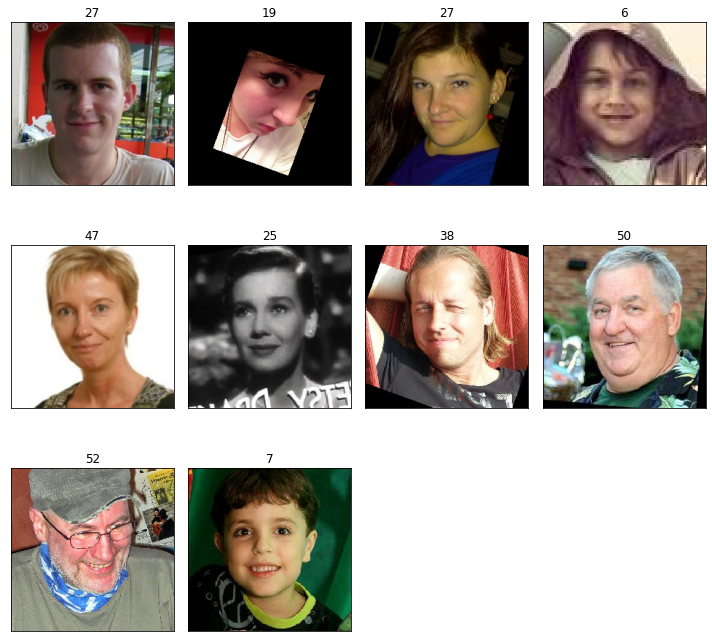

In [8]:
x, y = next(train_gen_flow)
fig = plt.figure(figsize = (10,10))
for i in range(10):
    fig.add_subplot(3,4, i+1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Из выведенных на экран примеров с изображениями можно заметить, что некоторые изображения находятся под углом (№2, 3, 7 и 8). В целом, на дальнейшее обучения это повлиять не должно, т.к. наоборот, обучаясь не на стандартно расположенных изображениях, модель покажет лучший результат. Также стоит отметить, что для дальнейшего повышения качества обучения, нами, еще на моменте создания генераторов картинок, была применена аугментация "горизонтальный поворот" для тренировочной выборки.

### Выводы

Таким образом, у нас получился датасет с 7951 картинок, на которых запечетлены люди, и столбца с указанием их реального возраста. 

Из построенного графика распледеления возрастов в выборке мы выяснили, что в диапазоне от 2-х лет до 71-го годабудут находиться практически все значения, встречающиеся в выборке (это наш 95%-й доверительный интервал). 
Также стоит отметить, что в нашей выборке преобладают молодые люди, что может сделать ошибку при распознавании лиц людей возрастом 72+ больше.

Затем мы разбили данные на выборки - тренировочную и тестовую в пропорциях 75/25 с помощью ImageDataGenerator, затем создали  загрузчик картинок в выборки отдельно для тренировочной и тестовой. При обучении модели тестовую выборку будем также использовать как валидационную. Для этого параметр validation_data сделаем равным test_data. 

На основании выведенных 12 изображений из тренировочного датасета заметно, что, действительно, подавляющее большинство выведенных картинок - это люди из диапазона "2-71 год" (конкретнее 6-52), отмеченного нами на графике ранее. Также видно, что достаточное количество изображений расположены как бы "под углом", что не должно повлиять на дальнейшее качество обученной модели. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Модель обучили на нейросети ResNet50, добавили оптимизатор Adam со значением learning_rate = 0.0001. Код для загрузчиков (ImageDataGenerator) использовали такой же, как и при разбитии на выборки. В качестве функции потерь применили MSE, а как метрику оценки MAE (что и требовалось в задании).

```python

from tensorflow.keras.applications.resnet import ResNet50 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam 
import numpy as np 
import pandas as pd 
    
def load_train(path): 
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator( 
                    validation_split=0.25, 
                    horizontal_flip=True, 
                    rescale=1./255) 
    train_gen_flow = train_datagen.flow_from_dataframe( 
                     dataframe=labels, 
                     directory=path + 'final_files/', 
                     x_col='file_name', 
                     y_col='real_age', 
                     target_size=(224, 224), 
                     batch_size=16, 
                     class_mode='raw', 
                     subset='training', 
                     seed=12345) 

    return train_gen_flow 

def load_test(path): 
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator( 
                   validation_split=0.25, 
                   rescale=1./255) 
    test_gen_flow = test_datagen.flow_from_dataframe( 
                    dataframe=labels, 
                    directory=path + 'final_files/', 
                    x_col='file_name', 
                    y_col='real_age', 
                    target_size=(224, 224), 
                    batch_size=16, 
                    class_mode='raw', 
                    subset='validation', 
                    seed=12345) 

    return test_gen_flow

def create_model(input_shape): 
    backbone = ResNet50(input_shape=input_shape, 
               weights='imagenet', 
               include_top=False) 
    model = Sequential() 
    model.add(backbone) 
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
 
    optimizer=Adam(learning_rate=0.0001) 
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) 
 
    return model 

def train_model(model, train_data, test_data, batch_size=None, epochs=5, 
                steps_per_epoch=None, validation_steps=None): 
    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size, epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2, shuffle=True) 

    return model


```

На выходе получаем такой процесс обучения и тестирования модели:

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
........
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 73s - loss: 225.3857 - mae: 10.7244 - val_loss: 324.5685 - val_mae: 13.4046
Epoch 2/5
356/356 - 42s - loss: 85.4940 - mae: 6.9780 - val_loss: 125.7155 - val_mae: 8.6380
Epoch 3/5
356/356 - 41s - loss: 59.4092 - mae: 5.9223 - val_loss: 88.3805 - val_mae: 6.7893
Epoch 4/5
356/356 - 41s - loss: 43.9057 - mae: 5.0455 - val_loss: 75.7226 - val_mae: 6.4610
Epoch 5/5
356/356 - 40s - loss: 34.8227 - mae: 4.5004 - val_loss: 69.4703 - val_mae: 6.2030
119/119 - 10s - loss: 69.4703 - mae: 6.2030
Test MAE: 6.2030

```

Таким образом, при обучении модели на 5 эпохах итоговая метрика МАЕ получилась равной 6,2030 - что, по условию задания, является отличным результатом.

## Анализ обученной модели

Наша модель была обучена на архитектуре сверточной нейросети ResNet50. Мы использовали 2D pooling, а также добавили в модель еще один слой (Dense) с 1 нейроном и фктивизатором relu. Про обучении использовали оптимизатор Adam с learning_rate = 0.0001.

На выводимом на экране прогрессе обучения модели по эпохам видно, что с каждой новой итерацией метрика МАЕ, равно как и функция потерь (MSE в нашеем случае) принимают все меньшие значения. Отсюда можно сделать вывод, что при большем количестве эпох обучения метрики качества обучения модели становятся лучше. 

Также стоит отметить, что аугментация тренировочной выборки тоже помогла.